Revert Classification - Demo
===

Building a classifier to predict reverts and produce calibrated propensity scores for being reverted.

This notebook is a pared-down demo notebook created for Solvejg.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration
from sklearn.model_selection import cross_val_score

In [4]:
from statistics import mean
import math

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join('/export/scratch2/levon003/repos/wiki-ores-feedback', "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [7]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Data loading and cleaning

In [8]:
# read in the sample dataframe
s = datetime.now()
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample3_filepath = os.path.join(revision_sample_dir, 'sample3_all.pkl')
rev_df = pd.read_pickle(sample3_filepath)
print(f"Sample 3 data loaded in {datetime.now() - s}.")
len(rev_df)

Sample 3 data loaded in 0:00:52.243535.


33964442

In [9]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
1,12,818613649,1515102279,0,0,0,True,818611292,818624114,1515101356,1515106953,[],-1,-1
2,12,818624114,1515106953,1,0,0,True,818613649,820024812,1515102279,1515798752,[],-1,-1
3,12,820024812,1515798752,0,1,0,True,818624114,820025687,1515106953,1515799060,[],820025687,1515799060
4,12,820025687,1515799060,0,0,1,True,820024812,820703495,1515798752,1516095884,[820024812],-1,-1
5,12,820703495,1516095884,0,0,0,True,820025687,821673418,1515799060,1516597634,[],-1,-1


In [10]:
# Load the features
s = datetime.now()
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
sample3_features_dir = os.path.join(labeled_revs_dir, 'sample3-features')
sample3_damaging_filepath = os.path.join(sample3_features_dir, 'sample3.damaging.2020-07-11T15:11:15Z.tsv')
features_df = pd.read_csv(sample3_damaging_filepath, sep='\t', header=0)
print(f"Features data loaded in {datetime.now() - s}.")
len(features_df)

Features data loaded in 0:02:10.167396.


4005652

In [11]:
# drop the useless 'damaging' column (it is auto-generated)
features_df = features_df.drop(columns='damaging')

In [641]:
features_df.head()

,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),feature.log((wikitext.revision.parent.headings + 1)),feature.log((wikitext.revision.parent.wikilinks + 1)),feature.log((wikitext.revision.parent.external_links + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,is_reverted
0,True,True,False,10.887885,9.786729,8.711773,5.252273,3.091042,5.817111,4.532599,...,4.333333,4.333333,0.000000,2,2,0,2.0,2.0,0.0,False
1,True,True,False,9.173676,7.996654,6.970730,2.833213,2.302585,4.262680,2.944439,...,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0.0,False
2,True,True,False,7.193686,6.049733,5.123964,2.197225,0.693147,2.564949,0.693147,...,1.333333,1.333333,0.000000,0,0,0,0.0,0.0,0.0,False
3,True,True,False,10.229440,9.153453,8.204672,2.944439,2.890372,4.605170,3.295837,...,-3.663679,1.015873,-4.679552,-1,0,-1,-0.2,0.0,-0.2,False
4,True,True,False,10.255763,9.185535,7.865188,4.812184,2.484907,4.836282,4.248495,...,-0.084034,0.058824,-0.142857,0,0,0,0.0,0.0,0.0,False


In [12]:
# load in the rev_ids that correspond to the feature data
# this is really slow, because it requires JSON decoding
# this could be made faster by caching the result
cache_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'sample3.mock.w_cache.2020-07-11T15:11:15Z.json')
cache_rev_id_list = []
with open(cache_filepath, 'r') as infile:
    for line in tqdm(infile, total=len(features_df)):
        rev = json.loads(line)
        rev_id = rev['rev_id']
        cache_rev_id_list.append(rev_id)

100%|██████████| 4005652/4005652 [03:34<00:00, 18674.65it/s]


In [13]:
assert len(cache_rev_id_list) == len(features_df)

In [14]:
cache_rev_id_set = set(cache_rev_id_list)
len(cache_rev_id_set)

4005602

In [15]:
# use use the last revision in this same to figure out when the analysis end time should be
last_rev = cache_rev_id_list[-1]
last_rev

826425205

In [16]:
# every rev_id in the cache should ALSO be in the rev_df
assert len(cache_rev_id_set & set(rev_df.rev_id)) == len(cache_rev_id_set), len(cache_rev_id_set & set(rev_df.rev_id))

In [17]:
# set the analysis start time to be the beginning of 2018
analysis_start_date = datetime.fromisoformat('2018-01-01')
analysis_start_date = analysis_start_date.replace(tzinfo=timezone.utc)
analysis_start_timestamp = int(analysis_start_date.timestamp())
print(f"Starting analysis from {datetime.utcfromtimestamp(analysis_start_timestamp)}")

Starting analysis from 2018-01-01 00:00:00


In [18]:
# note that this is less than 2 months of data right now!
# we have 20-25 million downloaded, but this 4 million set should be enough to get going
analysis_end_timestamp = rev_df[rev_df.rev_id == last_rev].rev_timestamp.iloc[0]
print(f"Using revisions up to {datetime.utcfromtimestamp(analysis_end_timestamp)}")

Using revisions up to 2018-02-19 07:18:15


In [19]:
# mostly to save memory, we trim out unneeded data in the rev_df
rev_df = rev_df[(rev_df.rev_timestamp <= analysis_end_timestamp)&(rev_df.rev_timestamp >= analysis_start_timestamp)]
len(rev_df)

4025634

In [20]:
# Read the revert info
# This dataframe contains additional data beyond what is in the rev_df
s = datetime.now()
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
print(f"Loaded revert data in {datetime.now() - s}.")
len(revert_df)

Loaded revert data in 0:01:08.067346.


5992682

The most important info in the `revert_df` that isn't in the `rev_df` is the username info, which enables the identification of self-reverts.

`revert_df` has one line per **revert** revision, compared to the `rev_df` which has one line per revision.

In [21]:
revert_df.head()

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]
3,18754864,1,853153047,1533256539,Beetstra,855858.0,831996274,1521801439,KolbertBot,31691822.0,[846149041],[1529188413],[Lepidoptera~plwiki],[24892933],False,False,[False]
4,18754916,1,882182106,1549557841,Number 57,327289.0,847748130,1530126769,CitationCleanerBot,15270283.0,[882125775],[1549520001],[Huldra],[410653],False,False,[False]


In [22]:
# identify self-reverts
is_self_revert_list = []
for row in tqdm(revert_df.itertuples(), total=len(revert_df)):
    is_self_revert = row.reverting_user_text in row.reverted_user_texts
    is_self_revert_list.append(is_self_revert)
revert_df['is_self_revert'] = is_self_revert_list

100%|██████████| 5992682/5992682 [00:20<00:00, 292460.22it/s]


In [23]:
# only keep reverts that appear in the (filtered) rev_df
analysis_rev_ids = set(rev_df.rev_id)
revert_subset = revert_df[revert_df.reverting_rev_id.isin(analysis_rev_ids)].copy()
len(revert_subset), len(revert_subset) / len(revert_df)

(427375, 0.07131614859590414)

In [24]:
# now compute the outcome, which is a variant of `rev_df.is_reverted`
reverted_rev_ids = set()
# only count it as a reverted revision if it was not a self-revert
# and it was reverted within one week
threshold = 60 * 60 * 24 * 7 
rs = revert_subset[~revert_subset.is_self_revert]
for row in tqdm(rs.itertuples(), total=len(rs)):
    reverting_timestamp = row.reverting_timestamp
    for rev_id, timestamp in zip(row.reverted_rev_ids, row.reverted_timestamps):
        if reverting_timestamp - timestamp <= threshold:
            reverted_rev_ids.add(rev_id)
len(reverted_rev_ids)

100%|██████████| 377374/377374 [00:02<00:00, 178143.07it/s]


501159

In [25]:
# just for fun, we'll compare how the revised revert outcome we computed in the cell above compares to 
# the broader definition of reverting
rev_df['is_reverted_for_damage'] = rev_df.rev_id.map(lambda rev_id: rev_id in reverted_rev_ids)

In [26]:
# our revised revert measure trims off 84251 of 499347 (16.9%) of the total reverts
# as expected, all revisions with is_reverted == 0 also have is_reverted_for_damage == 1
pd.crosstab(rev_df.is_reverted, rev_df.is_reverted_for_damage, margins=True)

is_reverted_for_damage,False,True,All
is_reverted,,,
0,3526287,0,3526287
1,84251,415096,499347
All,3610538,415096,4025634


In [27]:
84251 / 499347

0.16872235139091654

#### Create the actual outcome variable and add it to the features dataframe

`features_df` contains only the features, not the revision ids. We create a binary outcome column based on the order of the revisions as they were read from the cache (and stored in `cache_rev_id_list`).

In [28]:
is_reverted = [rev_id in reverted_rev_ids for rev_id in cache_rev_id_list]
features_df['is_reverted'] = is_reverted
np.sum(features_df.is_reverted), np.sum(features_df.is_reverted) / len(features_df)

(411650, 0.10276728981948506)

In [652]:
len(features_df)

4005652

### Fit classification models

#### Training and test data: first trying with test as last 20% of revisions

In [649]:
#Train/test split: test_a is last 20% of revisions, test_b is first 20%
train_a = features_df.head(math.floor(len(features_df)*.8))
test_a = features_df.tail(math.ceil(len(features_df)*.2))

train_b = features_df.tail(math.floor(len(features_df)*.8))
test_b = features_df.head(math.ceil(len(features_df)*.2))

In [651]:
print(train_a.shape)
print(test_a.shape)
print(train_b.shape)
print(test_b.shape)

(3204521, 81)
(801131, 81)
(3204521, 81)
(801131, 81)


In [653]:
# for the notebook use a sample of 10,000 from train_a
train_a_sample = train_a.sample(n=10000)

# scale X vars for all four data sets and sample
X_train_a_sample = sklearn.preprocessing.scale(train_a_sample.iloc[:,:-1])
X_train_a = sklearn.preprocessing.scale(train_a.iloc[:,:-1])
X_test_a = sklearn.preprocessing.scale(test_a.iloc[:,:-1])
X_train_b = sklearn.preprocessing.scale(train_b.iloc[:,:-1])
X_test_b = sklearn.preprocessing.scale(test_b.iloc[:,:-1])

In [656]:
train_a_sample.shape

(10000, 81)

#### Manually trying a few combinations of hyperparameters

In [719]:
# Zach's parameters
clfGB_a = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)
clfLR_a = sklearn.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter = 1000
)

# GB: max depth 10
clfGB_1 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2',
    max_depth=10
)
# GB: max depth = 5, max_features = 25
clfGB_2 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features=25,
    max_depth=5
)
# GB: max depth = 5, max_features = 50
clfGB_3 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features=50,
    max_depth=5
)

#### 8/16/20 Try these again if needed -- 'none' penalty did not work in old version of scikit-learn
# LR: C = 1, penalty = none
clfLR_1 = sklearn.linear_model.LogisticRegression(
    penalty='none',
    C=1,
    solver='lbfgs',
    max_iter = 1000
)
# LR: C = 0.25
clfLR_2 = sklearn.linear_model.LogisticRegression(
    penalty='l2',
    C=0.25,
    solver='lbfgs',
    max_iter = 1000
)

In [720]:
#Use train_a_sample and test_a
X_train = X_train_a_sample
train = train_a_sample
X_test = X_test_a
test = test_a

In [721]:
# Train GB models
# Use CalibratedClassifierCV, isotonic regression, to produce calibrated probability predictions for the test data
for clf, fname in [[clfGB_a, 'GB_a_sample'], [clfGB_1, 'GB_1_sample'], [clfGB_2, 'GB_2_sample'], [clfGB_3, 'GB_3_sample']]:
    clf_results = pd.DataFrame()
    s = datetime.now()
    print(clf)

    # train the model
    md = clf.fit(X_train, train.iloc[:,-1])
    
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    print(f"Training completed in {datetime.now() - s}.")
    
    # obtain calibrated probabilities
    ccCV = sklearn.calibration.CalibratedClassifierCV(md, method = 'isotonic', cv = 5)
    md_cc = ccCV.fit(X_train, train.iloc[:,-1])
    y_pred_test_calib = md_cc.predict_proba(X_test)[:,1]
    print(f"Calibration completed in {datetime.now() - s}.")

    # save results for this classifier in a dataframe
    clf_results['test_pred'] = y_pred_test
    clf_results['test_proba'] = y_pred_test_proba
    clf_results['test_label'] = np.array(test['is_reverted'])
    clf_results['test_calib'] = y_pred_test_calib
    print(clf_results.head())
    
    # save results dataframe to file
    clf_filepath = os.path.join('/export/scratch2/wastv004/wiki-ores-feedback/', fname + '.pkl')
    print(clf_filepath)
    
    clf_results.to_pickle(clf_filepath)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='log2',
                           n_estimators=700)
Training completed in 0:00:42.440083.
Calibration completed in 0:02:42.629070.
   test_pred  test_proba  test_label  test_calib
0      False    0.283173       False    0.212092
1      False    0.066261       False    0.055570
2      False    0.213318       False    0.205605
3      False    0.026192       False    0.025705
4      False    0.015213       False    0.008328
/export/scratch2/wastv004/wiki-ores-feedback/GB_a.pkl
GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='log2', n_estimators=700)
Training completed in 0:01:29.603636.
Calibration completed in 0:06:07.854522.
   test_pred  test_proba  test_label  test_calib
0      False    0.102765       False    0.222500
1      False    0.015715       False    0.043577
2      False    0.114356       False    0.211867
3      False    0.005167       False    0.014

In [722]:
# Train LR models
for clf, fname in [[clfLR_a, 'LR_a_sample'], [clfLR_1, 'LR_1_sample'], [clfLR_2, 'LR_2_sample']]:
    clf_results = pd.DataFrame()
    s = datetime.now()
    print(clf)
    
    # train the model
    md = clf.fit(X_train, train.iloc[:,-1])
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    
    print(f"Training completed in {datetime.now() - s}.")

    # save results for this classifier in a dataframe
    clf_results['test_pred'] = y_pred_test
    clf_results['test_calib'] = y_pred_test_proba
    clf_results['test_label'] = np.array(test['is_reverted'])
    
    print(clf_results.head())
    
    # save results dataframe to file
    clf_filepath = os.path.join('/export/scratch2/wastv004/wiki-ores-feedback/', fname + '.pkl')
    print(clf_filepath)
    
    clf_results.to_pickle(clf_filepath)

LogisticRegression(max_iter=1000)
Training completed in 0:00:00.474241.
   test_pred  test_calib  test_label
0      False    0.345328       False
1      False    0.038675       False
2      False    0.252290       False
3      False    0.024526       False
4      False    0.008796       False
/export/scratch2/wastv004/wiki-ores-feedback/LR_a.pkl
LogisticRegression(C=0.5, max_iter=1000)
Training completed in 0:00:00.331411.
   test_pred  test_calib  test_label
0      False    0.335969       False
1      False    0.038130       False
2      False    0.256969       False
3      False    0.023922       False
4      False    0.008849       False
/export/scratch2/wastv004/wiki-ores-feedback/LR_1.pkl
LogisticRegression(C=0.25, max_iter=1000)
Training completed in 0:00:00.308575.
   test_pred  test_calib  test_label
0      False    0.329970       False
1      False    0.038437       False
2      False    0.254584       False
3      False    0.023642       False
4      False    0.009013       F

### Calibration, F-measure, AUC, Hosmer-Lemeshow test
Importing saved data

In [748]:
GBa_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/GB_a.pkl')
GB1_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/GB_1.pkl')
GB2_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/GB_2.pkl')
GB3_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/GB_3.pkl')

LRa_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/LR_a.pkl')
#LR1_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/LR_1_sample.pkl')
#LR2_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/LR_2_sample.pkl')

In [749]:
GB3_results.head()

,test_pred,test_proba,test_label,test_calib
0,False,0.172227,False,0.163061
1,False,0.053503,False,0.057279
2,False,0.216023,False,0.228405
3,False,0.060946,False,0.065177
4,False,0.011038,False,0.004507


In [757]:
# Hosmer-Lemeshow goodness of fit test
from scipy.stats import chi2, norm
def hl_test_b(data, g):
    '''
    Input: dataframe(data), integer(num of subgroups divided)
    
    Output: float
    '''
    data_st = data.sort_values('test_calib')
    data_st['dcl'] = pd.qcut(data_st['test_calib'], g)
    
    
    o_true = data_st['test_label'].groupby(data_st.dcl).sum()
    #count() gives count of non-NA cells
    o_t = data_st['test_label'].groupby(data_st.dcl).count()
    o_false = o_t - o_true
    #print('Observed True')
    #print(o_true)
    #print('Observed Total')
    #print(o_t)
    #print('Total "True" labels: {}'.format(o_true.sum()))
    #print('Total "False" labels: {}'.format(o_false.sum()))
    #print('Total observations: {}'.format(o_t.sum()))
    
    e_true = data_st['test_calib'].groupby(data_st.dcl).sum()
    e_t = data_st['test_calib'].groupby(data_st.dcl).count()
    e_false = e_t - e_true
    #print('Expected True')
    #print(e_true)
    #print('Expected Total')
    #print(e_t)
    
    hltest_list = ( ((o_true - e_true)**2 / e_true) + ((o_false - e_false)**2 / e_false) )
    hltest = hltest_list.sum()
    pval = 1 - chi2.cdf(hltest, g-2)
    
    degfree = g-2
    
    #print('\n HL-chi2({}): {}, p-value: {}\n'.format(degfree, hltest, pval))
    return hltest

In [768]:
clf_eval_results = {}
#[clfLR_1, LR1_results, 'LR1'], [clfLR_2, LR2_results, 'LR2']
for clf, results, label in [[clfGB_a, GBa_results, 'GBa (maxfeatures: ~6, maxdepth: 5)'], [clfGB_1, GB1_results, 'GB1 (maxfeatures: ~6, maxdepth: 10)'], [clfGB_2, GB2_results, 'GB2 (maxfeatures: 25, maxdepth: 5)'], [clfGB_3, GB3_results, 'GB3 (maxfeatures: 50, maxdepth: 5)'],
                            [clfLR_a, LRa_results, 'LRa']]:
    print(label)
    # calibration statistic, F1 score, and AUC
    auc = sklearn.metrics.roc_auc_score(results['test_label'], results['test_calib'])
    prf1 = sklearn.metrics.precision_recall_fscore_support(results['test_label'], results['test_pred'])
    #hl = hl_test_b(results, 5)
    print(sklearn.metrics.classification_report(results['test_label'], results['test_pred']))

    clf_eval_results[label] = {'auc': auc, 'prf1': prf1}

GBa (maxfeatures: ~6, maxdepth: 5)
              precision    recall  f1-score   support

       False       0.92      0.99      0.96    727656
        True       0.77      0.19      0.31     73475

    accuracy                           0.92    801131
   macro avg       0.85      0.59      0.63    801131
weighted avg       0.91      0.92      0.90    801131

GB1 (maxfeatures: ~6, maxdepth: 10)
              precision    recall  f1-score   support

       False       0.93      0.98      0.96    727656
        True       0.67      0.32      0.43     73475

    accuracy                           0.92    801131
   macro avg       0.80      0.65      0.69    801131
weighted avg       0.91      0.92      0.91    801131

GB2 (maxfeatures: 25, maxdepth: 5)
              precision    recall  f1-score   support

       False       0.93      0.99      0.96    727656
        True       0.74      0.24      0.36     73475

    accuracy                           0.92    801131
   macro avg       0.8

GBa (maxfeatures: ~6, maxdepth: 5); validation ROC AUC: 0.8798; % reverted; 0.10199259115265978
GB1 (maxfeatures: ~6, maxdepth: 10); validation ROC AUC: 0.8871; % reverted; 0.12271254629342729
GB2 (maxfeatures: 25, maxdepth: 5); validation ROC AUC: 0.8811; % reverted; 0.10172537067594671
GB3 (maxfeatures: 50, maxdepth: 5); validation ROC AUC: 0.8819; % reverted; 0.10254216827158859
LRa; validation ROC AUC: 0.8633; % reverted; 0.10636279630018411


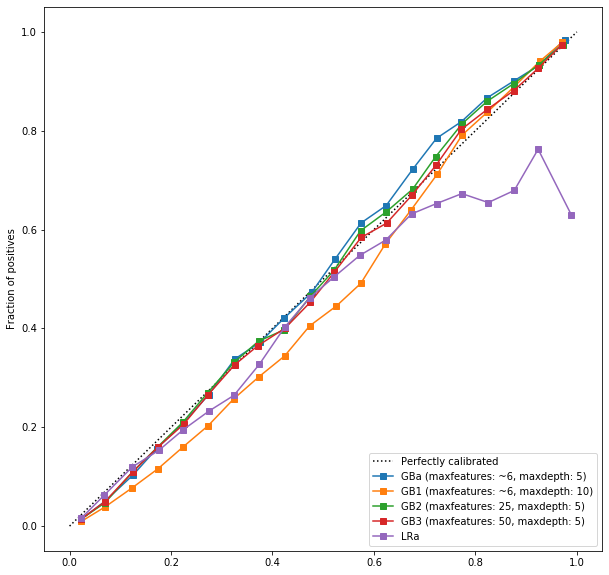

In [769]:
fig = plt.figure(0, figsize=(10, 10))
ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#[LR1_results, 'LR1'], [LR2_results, 'LR2'], 
for results, clf in [[GBa_results, 'GBa (maxfeatures: ~6, maxdepth: 5)'], [GB1_results, 'GB1 (maxfeatures: ~6, maxdepth: 10)'], [GB2_results, 'GB2 (maxfeatures: 25, maxdepth: 5)'], [GB3_results, 'GB3 (maxfeatures: 50, maxdepth: 5)'], 
                     [LRa_results, 'LRa']]:
    labels = results['test_label']
    pred = results['test_calib']
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(labels, pred, n_bins=20)

    ax.plot(mean_pred_value, frac_of_pos, "s-", label=clf)
    ax.set_ylabel("Fraction of positives")
    
    acc_test = np.sum(pred == labels) / len(pred)
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print(f"{clf}; validation ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(pred) / len(labels)}")
    
ax.set_ylim([-0.05, 1.05])
ax.legend(loc="lower right")

plt.show()

GB2 (maxfeatures: 25, maxdepth: 5); validation ROC AUC: 0.8811; % reverted; 0.10172537067594671
GB3 (maxfeatures: 50, maxdepth: 5); validation ROC AUC: 0.8819; % reverted; 0.10254216827158859


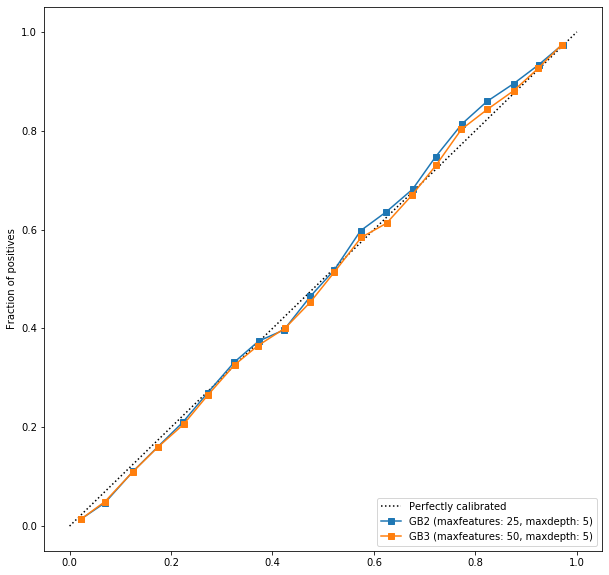

In [770]:
fig = plt.figure(0, figsize=(10, 10))
ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for results, clf in [[GB2_results, 'GB2 (maxfeatures: 25, maxdepth: 5)'], [GB3_results, 'GB3 (maxfeatures: 50, maxdepth: 5)']]:
    labels = results['test_label']
    pred = results['test_calib']
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(labels, pred, n_bins=20)

    ax.plot(mean_pred_value, frac_of_pos, "s-", label=clf)
    ax.set_ylabel("Fraction of positives")
    
    acc_test = np.sum(pred == labels) / len(pred)
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print(f"{clf}; validation ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(pred) / len(labels)}")
    
ax.set_ylim([-0.05, 1.05])
ax.legend(loc="lower right")

plt.show()

In [6]:
derived_data_dir = os.path.join('/export/scratch2/levon003/repos/wiki-ores-feedback', "data", "derived")
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
revid_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'rev_id_2020-08-01T05:40:00Z.txt')

rev_id_list = pd.read_csv(revid_filepath, header=None)
rev_id_list.head()


,0
0,857219031
1,857219035
2,857219034
3,857219036
4,857219037


### Evaluation of prediction on 08-01-2020 data

In [11]:
results_0801 = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/prediction_2020-08-01.pkl')

In [14]:
# label probabilities >= 0.5 as true
def label_pred (row):
    if row['test_calib'] >= 0.5:
        return True
    else:
        return False

results_0801['test_pred'] = results_0801.apply(lambda row: label_pred(row), axis = 1)

GB3 (maxfeatures: 50, maxdepth: 5); validation ROC AUC: 0.8773; % reverted; 0.09653282261655155
              precision    recall  f1-score   support

       False       0.92      0.99      0.96  10571172
        True       0.75      0.24      0.37   1167173

    accuracy                           0.92  11738345
   macro avg       0.84      0.62      0.66  11738345
weighted avg       0.91      0.92      0.90  11738345



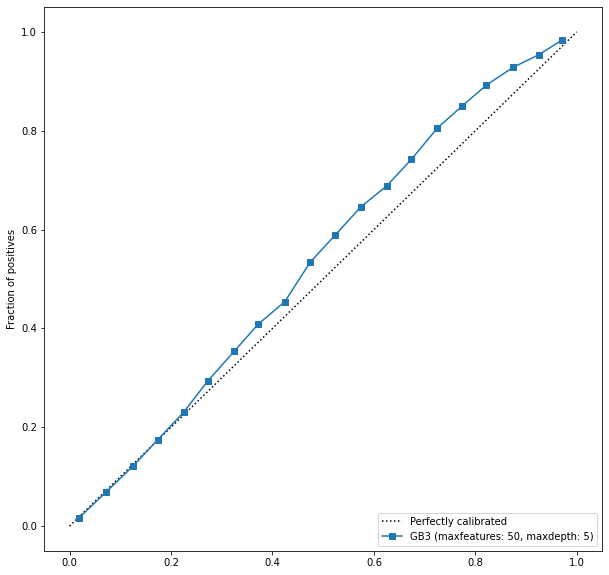

In [15]:
fig = plt.figure(0, figsize=(10, 10))
ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for results, clf in [[results_0801, 'GB3 (maxfeatures: 50, maxdepth: 5)']]:
    labels = results['test_label']
    pred = results['test_calib']
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(labels, pred, n_bins=20)

    ax.plot(mean_pred_value, frac_of_pos, "s-", label=clf)
    ax.set_ylabel("Fraction of positives")
    
    acc_test = np.sum(pred == labels) / len(pred)
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print(f"{clf}; validation ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(pred) / len(labels)}")
    print(sklearn.metrics.classification_report(results['test_label'], results['test_pred']))
    
ax.set_ylim([-0.05, 1.05])
ax.legend(loc="lower right")

plt.show()

### Other models
Random forest

In [16]:
RF1_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/RF_100_10_10_1.pkl')
RF2_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/RF_100_50_10_1.pkl')
RF3_results = pd.read_pickle('/export/scratch2/wastv004/wiki-ores-feedback/RF_100_50_10_50.pkl')

RF 1 (maxfeatures: 10, maxdepth: 10, min per leaf: 1); validation ROC AUC: 0.8769; % reverted; 0.10271334785390167
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    727656
        True       0.83      0.14      0.24     73475

    accuracy                           0.92    801131
   macro avg       0.87      0.57      0.60    801131
weighted avg       0.91      0.92      0.89    801131

RF 2 (maxfeatures: 50, maxdepth: 10, min per leaf: 1); validation ROC AUC: 0.8676; % reverted; 0.10775900146074498
              precision    recall  f1-score   support

       False       0.93      0.99      0.96    727656
        True       0.72      0.23      0.35     73475

    accuracy                           0.92    801131
   macro avg       0.82      0.61      0.65    801131
weighted avg       0.91      0.92      0.90    801131

RF 3 (maxfeatures: 50, maxdepth: 10, min per leaf: 50); validation ROC AUC: 0.8765; % reverted; 0.10221493388028374


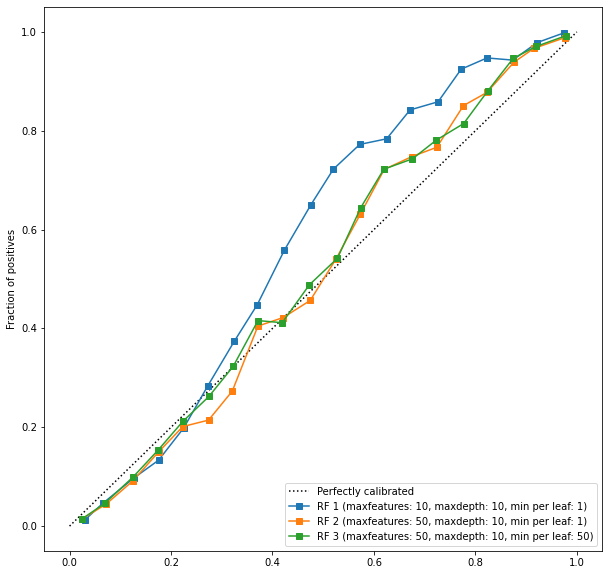

In [18]:
fig = plt.figure(0, figsize=(10, 10))
ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1)

ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for results, clf in [[RF1_results, 'RF 1 (maxfeatures: 10, maxdepth: 10, min per leaf: 1)'],
                    [RF2_results, 'RF 2 (maxfeatures: 50, maxdepth: 10, min per leaf: 1)'],
                    [RF3_results, 'RF 3 (maxfeatures: 50, maxdepth: 10, min per leaf: 50)']]:
    labels = results['test_label']
    pred = results['test_calib']
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(labels, pred, n_bins=20)

    ax.plot(mean_pred_value, frac_of_pos, "s-", label=clf)
    ax.set_ylabel("Fraction of positives")
    
    acc_test = np.sum(pred == labels) / len(pred)
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print(f"{clf}; validation ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(pred) / len(labels)}")
    print(sklearn.metrics.classification_report(results['test_label'], results['test_pred']))
    
ax.set_ylim([-0.05, 1.05])
ax.legend(loc="lower right")

plt.show()